Le but de ce projet est d'appliquer le modèle AKM à un graphe bi-partite simple.

# Importation de packages

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import fonctionsAKM
from tqdm import tqdm

# Création du Graphe

On commence par créer une instance de notre graphe bipartite. 

On se place dans un contexte médicale avec un certains nombres de patients i et de docteurs j.

Leurs positions repsectives sont générées alléatoirement sur [0;1]x[0;1] et on calcule les distance Xij.

In [2]:
nombre_patient=100
nombre_docteur=30

In [3]:
akm = fonctionsAKM.graph_AKM(nombre_patient, nombre_docteur)

On génère ensuite des effets fixes pour les médecins et les docteurs.
L'effet fixe du patient peut correspondre à son état de santé global et celui du docteur, sa renomée

In [4]:
alpha = np.random.randint(0,3,size=akm.nombre_patient)/10
psi = np.random.randint(0,3,size=akm.nombre_docteur)/10
beta_lien = 3.5

On génère ensuite la matirce des liens selon le modèle suivant:

$lien_{ij}$ suit un loi de Bernouilli de paramètre $\frac{e^{\lambda_{ij}}}{1+e^{\lambda_{ij}}}$ où:

 $\lambda_{ij}= - \beta lien * distance_{ij} - effetpatient_i + effetdocteur_j $

/home/onyxia/work/Embedding/fonctionsAKM.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([self.position_docteur[0][j], self.position_patient[0][i]], [self.position_docteur[1][j], self.position_patient[1][i]], 'k-',alpha=0.5,color="green")


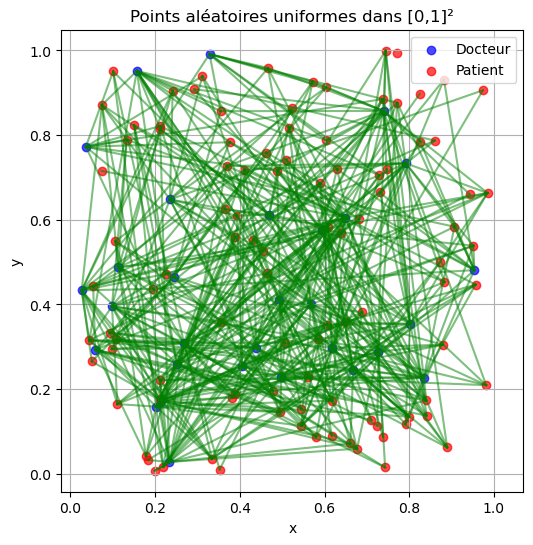

In [5]:
akm.create_link(alpha, psi, beta_lien)

# Modèle AKM

Ensuite, on génère un prix de consultation potentiel $Y^*$ selon le modèle suivant:

Pour des effets fixes:

$\alpha_i$ du docteur $i$ et $\psi_j$ du patient $j$. (par exemple la gravité de la maladie et si le docteur est bon ou non)

$Y^*_{ij} = constente + \alpha_i + \psi_j + \beta*distance_{ij} + \epsilon_{ij} \quad$  où $\epsilon_{ij} \sim_{iid} \mathcal{N}(0,1)$

On considère ensuite $Y=Lien \times Y^*$, le prix observé, et on résout avec AKM.

In [6]:
alpha_sante = np.random.randint(0,3,size=akm.nombre_patient)
psi_sante = -np.random.randint(0,3,size=akm.nombre_docteur)
psi_sante[len(psi_sante)-1]=0

print("effet fixe patient:", alpha_sante)
print("")
print("effet fixe docteur:", psi_sante)

effet fixe patient: [0 2 2 0 1 2 0 1 1 2 1 2 1 0 0 0 0 0 1 2 1 2 1 2 0 0 2 2 0 0 1 1 1 2 1 1 1
 0 2 1 0 0 0 0 1 2 0 2 1 0 2 0 2 2 0 2 0 1 1 0 1 1 1 2 0 1 0 0 2 2 2 2 0 1
 0 0 1 2 2 1 0 0 0 0 1 1 1 2 2 1 1 1 0 0 1 2 1 1 1 2]

effet fixe docteur: [-1  0  0  0 -1 -1 -2  0 -1  0 -2  0  0 -1 -2 -2  0 -1 -1  0 -1 -2 -2 -1
  0 -1 -1 -2 -1  0]


In [7]:
estimation = akm.solve_model(alpha_sante, psi_sante, 4, 3 )

print("la constante estimée est:", estimation[0][0])
print("")
print("le beta estimée est:", estimation[0][1])
print("")
print("les effets des patients estimés sont:", estimation[1][:3],"...")
print("")
print("lest effets des docteurs estimés sont:", estimation[2][:3],"...")


la constante estimée est: [4.93067459]

le beta estimée est: [0.54261745]

les effets des patients estimés sont: [0.82029616 2.05247051 1.83680389] ...

lest effets des docteurs estimés sont: [-1.11795864  0.03458737 -0.1128959 ] ...


On peut ensuite mesurer la performance du modèle et en particulier les MSE:

In [8]:
a = akm.show_perf(alpha_sante, psi_sante, constente=4, beta=3 ) 

Le mse_prix vaut: 1.4356666666666666
Le mse_alpha vaut: 0.32786713818084484
Le mse_psi vaut: 0.1192799343759256


# Scalabilité du modèle

On veut voir comment évolue la qualité de l'estimation des effets fixes avec la densité du graph. 

Pour cela on fixe un modèle pour les prix mais on change les paramètres du modèle de création des liens.

In [23]:
def scalabilité(nombre_patient, nombre_docteur, beta_lien_min, beta_lien_max, alpha, psi, alpha_sante, psi_sante, beta, constente, nb_points):
    akm = fonctionsAKM.graph_AKM(nombre_patient, nombre_docteur)
    
    t=np.linspace(beta_lien_min,beta_lien_max, nb_points)
    x=[]
    y=[]
    z=[]
    s=[]
    for i in tqdm(t):
        akm.create_link(alpha, psi, i, show=False)
        perfs=akm.show_perf(alpha_sante, psi_sante, constente, beta, show=False)
        x.append(perfs[0])
        y.append(perfs[1])
        z.append(perfs[2])
        s.append(int(akm.lien.sum())/(nombre_patient*nombre_docteur))
    
    data = list(zip(s, x, y, z))

    # Trier par x
    data_sorted = sorted(data, key=lambda t: t[0])

    # Dézipper
    s, x, y, z = zip(*data_sorted)
    
    plt.plot(s, x, label="mse modèle")
    plt.plot(s, y, label="mse patient")
    plt.plot(s, z, label="mse docteur")

    # Ajouter des labels et un titre
    plt.xlabel("sparcité")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Différents MSE")
    plt.grid(True)

    # Afficher le graphique
    plt.show()

100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


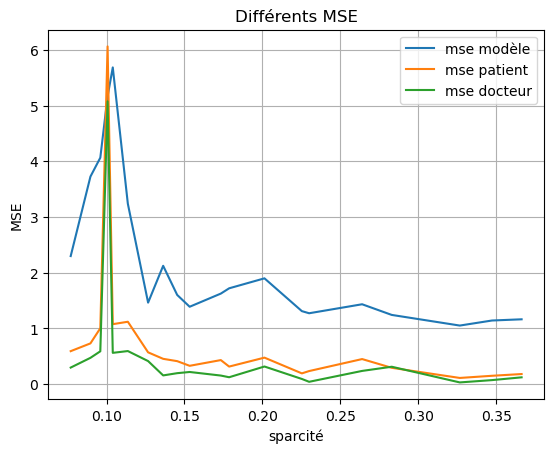

In [26]:
scalabilité(nombre_patient, nombre_docteur, 1, 6, alpha, psi, alpha_sante, psi_sante, 3, 4, 20)
